This is Week homework from [Statistical Rethinking](https://github.com/rmcelreath/stat_rethinking_2020/tree/main/homework) using Python. (A public repo using `pmyc3` has been created [here](https://github.com/pymc-devs/resources/tree/master/Rethinking_2) that also uses Python. It will helpful for me to do these exercises myself, but that repo will serve as a helpful reference.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns

from scipy.optimize import curve_fit

In [2]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

<IPython.core.display.Javascript object>

All three problems below are based on the same data. The data in `data(foxes)` are 116 foxes from 30 different urban groups in England. These foxes are like street gangs. Group size varies from 2 to 8 individuals. Each group maintains its own (almost exclusive) urban territory. Some territories are larger than others. The `area` variable encodes this information. Some territories also have more `avgfood` than others. We want to model the `weight` of each fox. For the problems below, assume this DAG:

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


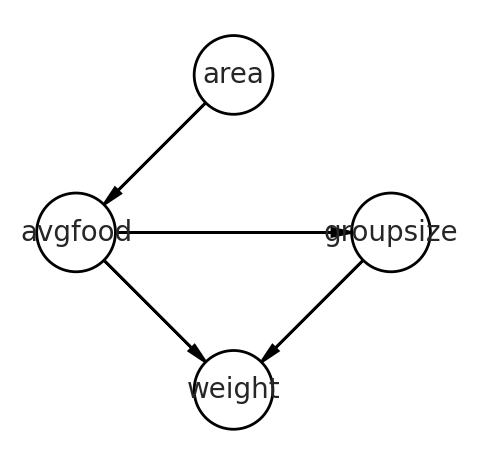

<IPython.core.display.Javascript object>

In [3]:
import daft
from causalgraphicalmodels import CausalGraphicalModel

fox_dag = CausalGraphicalModel(
    nodes=["area", "avgfood", "groupsize", "weight"],
    edges=[
        ("area", "avgfood"),
        ("avgfood", "groupsize"),
        ("avgfood", "weight"),
        ("groupsize", "weight"),
    ],
)
pgm = daft.PGM()
coordinates = {
    "area": (1, 1),
    "avgfood": (0, 0),
    "groupsize": (2, 0),
    "weight": (1, -1),
}
for node in fox_dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in fox_dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
# plt.gca().invert_yaxis()

Right away, we see that `weight` (the outcome) is a collider of `avgfood` and `groupsize`.

In [4]:
# Run R code to get foxes data
#%load_ext rpy2.ipython

<IPython.core.display.Javascript object>

In [5]:
# %%R
# suppressMessages(library(rethinking))
# data(foxes)
# write.csv(foxes, "../data/a_input/foxes.csv", sep=',', row.names=FALSE)

<IPython.core.display.Javascript object>

# Inspect data

In [4]:
d = pd.read_csv("../data/a_input/foxes.csv", header=0)
d.head()

,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84
2,2,0.53,2,2.05,5.33
3,2,0.53,2,2.05,6.07
4,3,0.49,2,2.12,5.85


<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='area', ylabel='weight'>

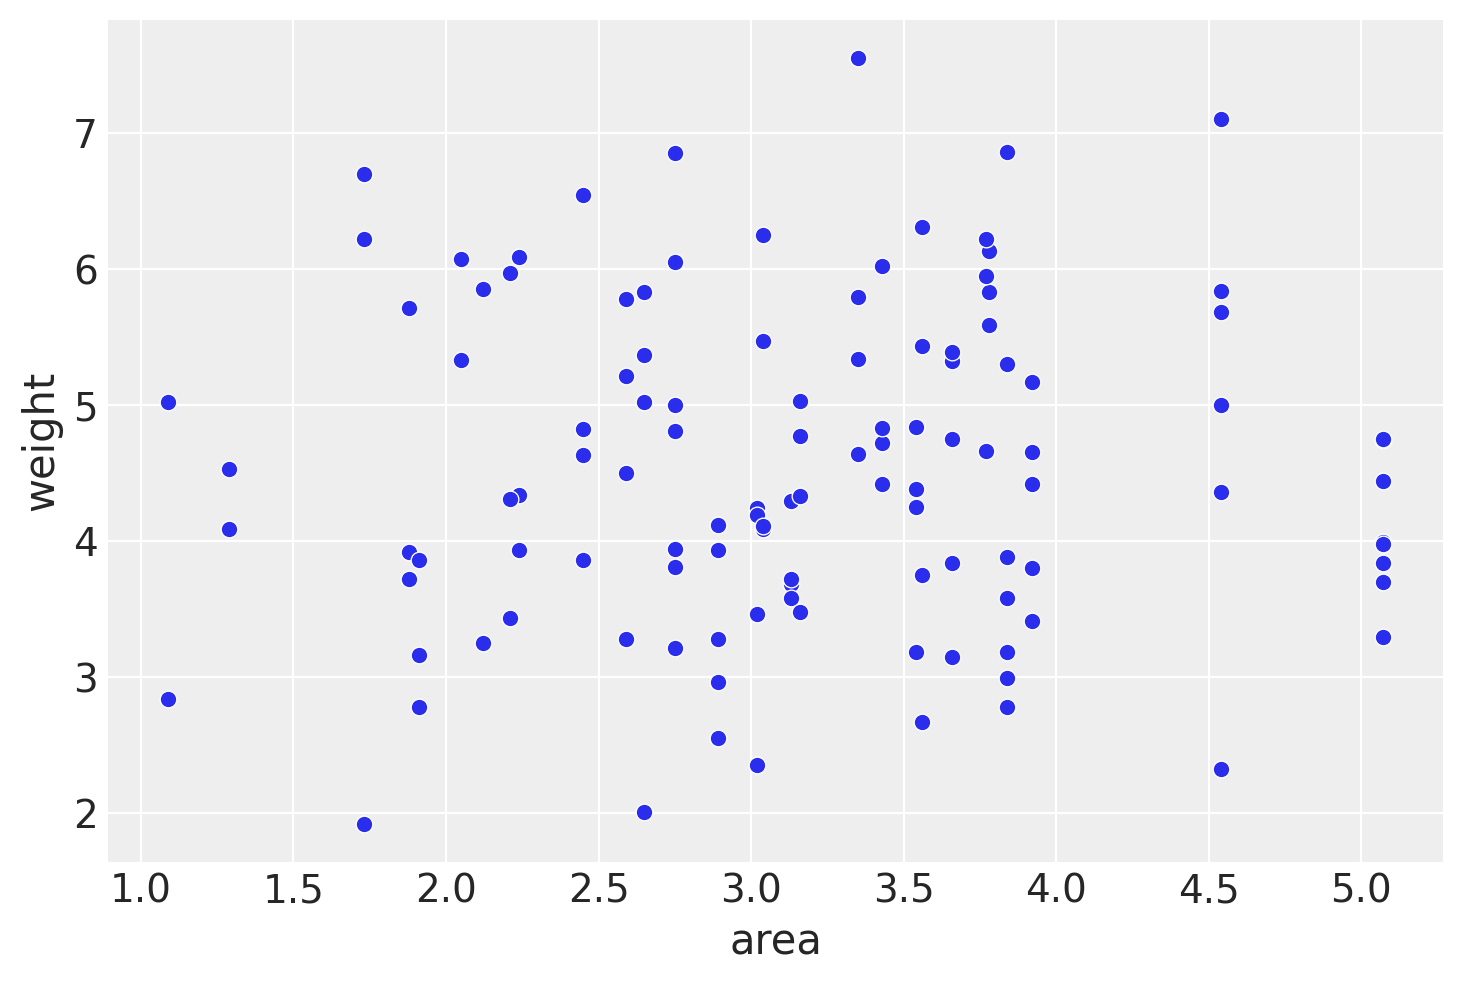

<IPython.core.display.Javascript object>

In [5]:
f, ax1 = plt.subplots()
sns.scatterplot(data=d, x="area", y="weight", ax=ax1)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


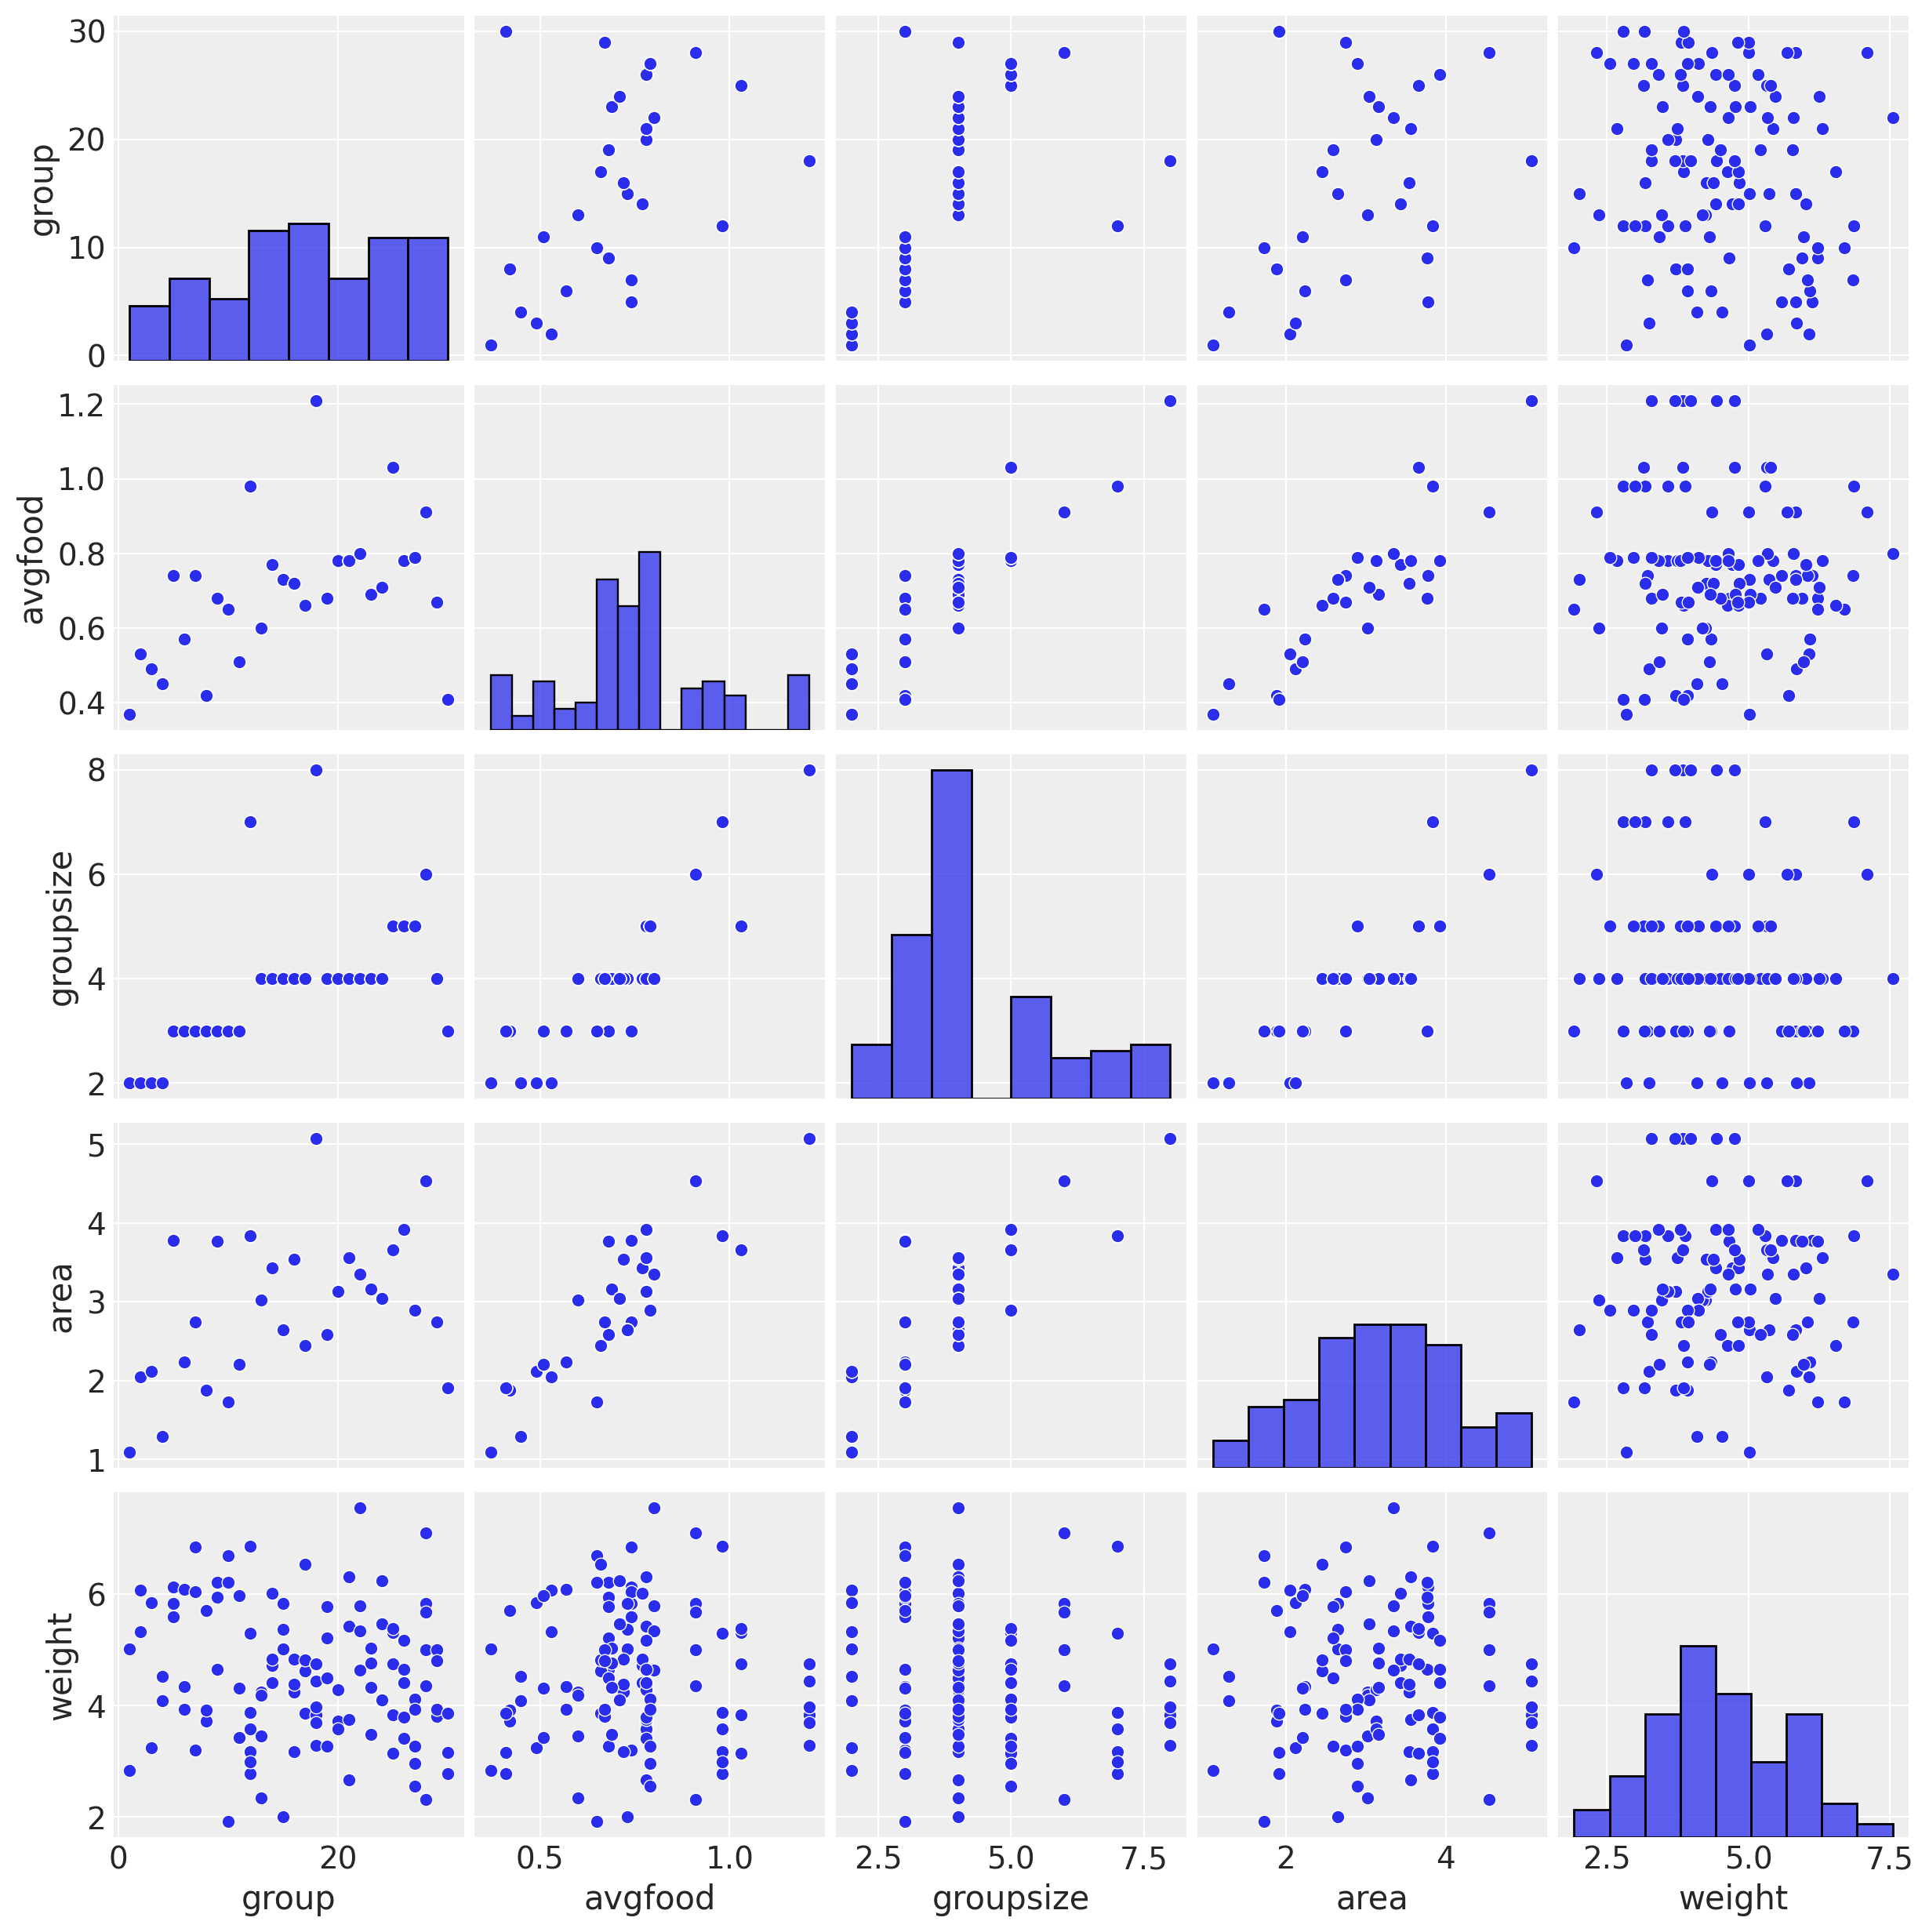

<IPython.core.display.Javascript object>

In [6]:
sns.pairplot(d)

# Question 1

**Use a model to infer the total causal influence of `area` on `weight`. Would increasing the area available to each fox make it heavier (healthier)? You might want to standardize the variables. Regardless, use prior predictive simulation to show that your model’s prior predictions stay within the possible outcome range.**


Full model would include group as a categorical variable, but it looks like this can be ignored for now. My initial intuition was to setup a multiple regression model with the features `avgfood`, `groupsize`, `area`, and `weight`. However, for this question,  `avgfood` is a piping collider between `area` and `weight`. In this instance, we would omit `avgfood`, to properly determine the causal impact of `area`.

$\text{weight}_i$ ~ Normal($\mu_i, \sigma$)
<br>
$\mu_i = \alpha + \beta_{\text{area}}x_i$
<br>
$\alpha$ ~ $\text{Normal}(0, 2)$
<br>
$\beta_{\text{area}}$ ~ $\text{Log-Normal}(0, 1)$
<br>
$\sigma$ ~ $\text{Exp}(1)$

Notes on prior parameters:
- I am naive about a wolf's average weight ($\alpha$) which is why standardizing ahead of time is good practice. I can determine my prior distribution values based on a standardized normal distribution (assuming ~95% of values will be represented). The arguments for standardization apply to both $\beta_{\text{area}}$ and $\sigma$.
- For $\beta_{\text{area}}$, I would assume that larger areas would lead to larger weights and hence I have used the log-normal distribution there.
- Standardization of the feature space means I don't have to subtract the mean in the calculation of $\mu_i$.
- For $\sigma$, I am assuming an average deviation.

With regards to using the [exponential distribution](https://en.wikipedia.org/wiki/Exponential_distribution) as a prior. This is taken from the textbook, Chapter 4, in a different example:

>  Exponential distributions are useful priors for scale parameters, parameters that must be positive. The prior for σ is exponential with a rate of 1. That average is the inverse of the rate. So in this case it is 1/1=1. If the rate were 0.5, the mean would be 1/0.5=2. We’ll use exponential priors for the rest of the book, in place of uniform priors. It is much more common to have a sense of the average deviation than of the maximum.

## Standardize columns

In [7]:
d2 = d.copy()
col2standardize = ["avgfood", "groupsize", "area", "weight"]
d2[col2standardize] = (d[col2standardize] - d[col2standardize].mean()) / d[
    col2standardize
].std()

<IPython.core.display.Javascript object>

In [8]:
d2.head()

,group,avgfood,groupsize,area,weight
0,1,-1.924829,-1.524089,-2.239596,0.414135
1,1,-1.924829,-1.524089,-2.239596,-1.427046
2,2,-1.118035,-1.524089,-1.205508,0.675954
3,2,-1.118035,-1.524089,-1.205508,1.300942
4,3,-1.319734,-1.524089,-1.130106,1.115135


<IPython.core.display.Javascript object>

## Setup model

In [9]:
with pm.Model() as weights_model:

    # Priors are variables a, b_area, sigma
    a = pm.Normal("a", mu=0, sd=2)
    b_area = pm.Lognormal("b_area", mu=0, sd=1)
    sigma = pm.Exponential("sigma", 1)

    # Linear model
    # Data included here (d2['area'] which is observed)
    mu = a + b_area * (d2["area"])

    # Likelihood is height variable, which is also observed (data included here, d2.height))
    # Height is dependent on deterministic and stochastic variables
    weight = pm.Normal("weight", mu=mu, sd=sigma, observed=d2["weight"])

    # This next line is doing the fitting and sampling all at once.
    # Using return_inferencedata = True to use arviz objects directly
    trace_m = pm.sample(1000, tune=1000, return_inferencedata=True)

    # Prior checks
    prior_checks = pm.sample_prior_predictive(samples=50, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_area, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


<IPython.core.display.Javascript object>

## Prior predictive checks

Code taken from [here](https://docs.pymc.io/notebooks/posterior_predictive.html)

Text(0.5, 1.0, 'Prior predictive checks')

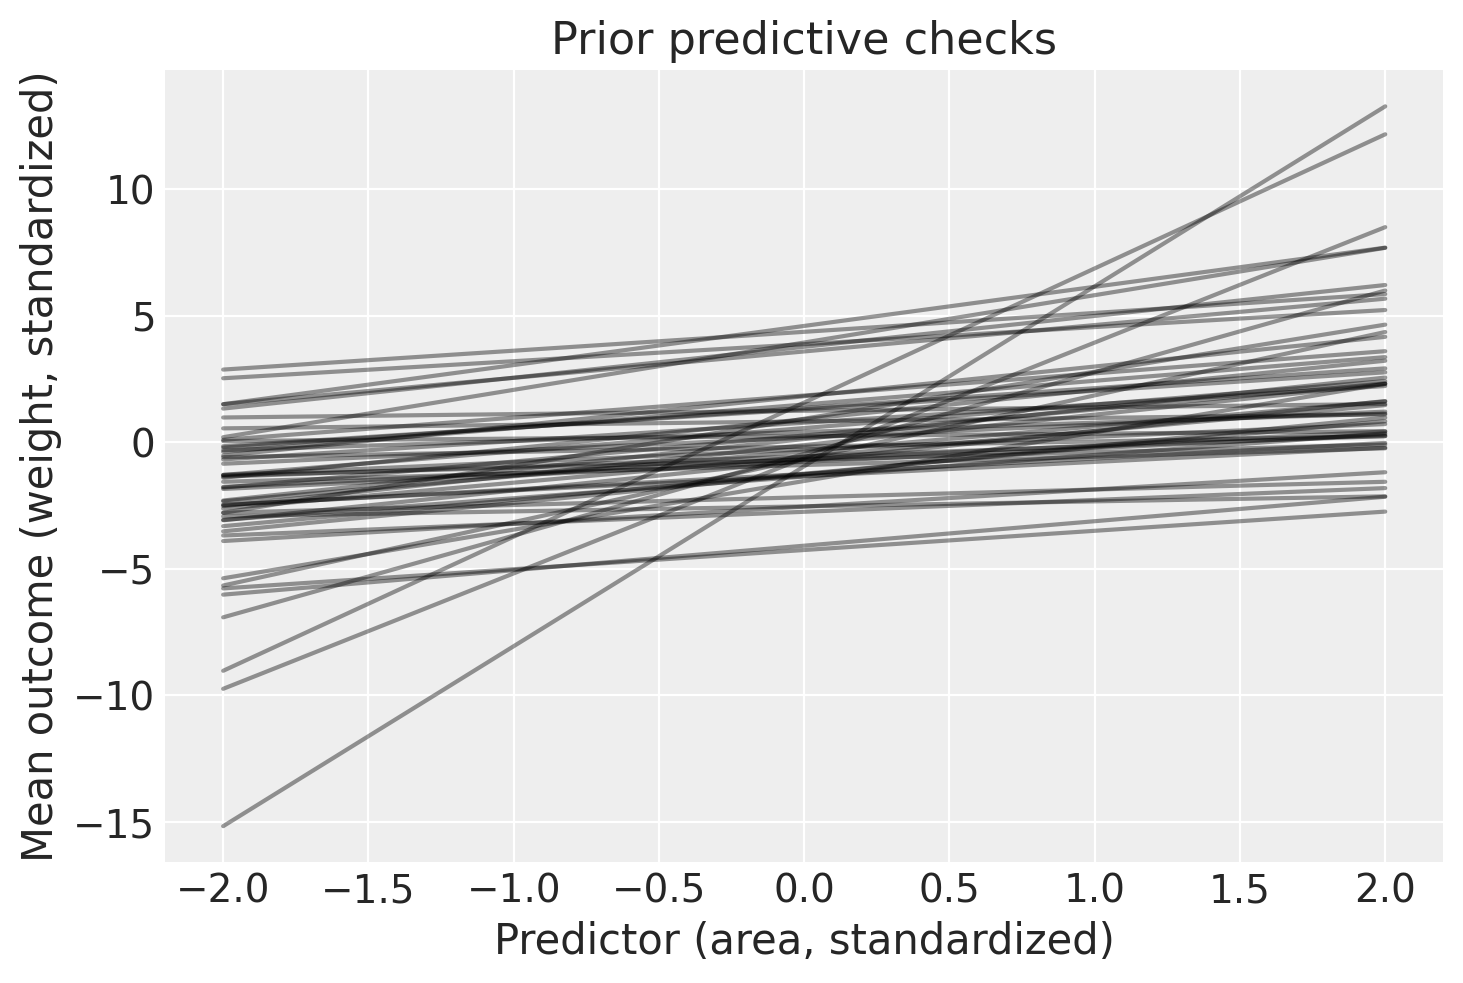

<IPython.core.display.Javascript object>

In [10]:
_, ax = plt.subplots()

x = np.linspace(-2, 2, 50)

for a, b in zip(prior_checks["a"], prior_checks["b_area"]):
    y = a + b * x
    ax.plot(x, y, c="k", alpha=0.4)

ax.set_xlabel("Predictor (area, standardized)")
ax.set_ylabel("Mean outcome (weight, standardized)")
ax.set_title("Prior predictive checks")

This mostly okay except there are just a few lines that are predicting things that are way off. What is a way to tighten the prior? I'll decrease the `sd` for `b_area`.

In [11]:
with pm.Model() as weights_model2:

    # Priors are variables a, b_area, sigma
    a = pm.Normal("a", mu=0, sd=2)
    b_area = pm.Lognormal("b_area", mu=0, sd=0.5)  # Make this smaller
    sigma = pm.Exponential("sigma", 1)

    # Linear model
    # Data included here (d2['area'] which is observed)
    mu = a + b_area * (d2["area"])

    # Likelihood is height variable, which is also observed (data included here, d2.height))
    # Height is dependent on deterministic and stochastic variables
    weight = pm.Normal("weight", mu=mu, sd=sigma, observed=d2["weight"])

    # This next line is doing the fitting and sampling all at once.
    # Using return_inferencedata = True to use arviz objects directly
    trace_m2 = pm.sample(1000, tune=1000, return_inferencedata=True)

    # Prior checks
    prior_checks2 = pm.sample_prior_predictive(samples=50, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_area, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Prior predictive checks (model 2)')

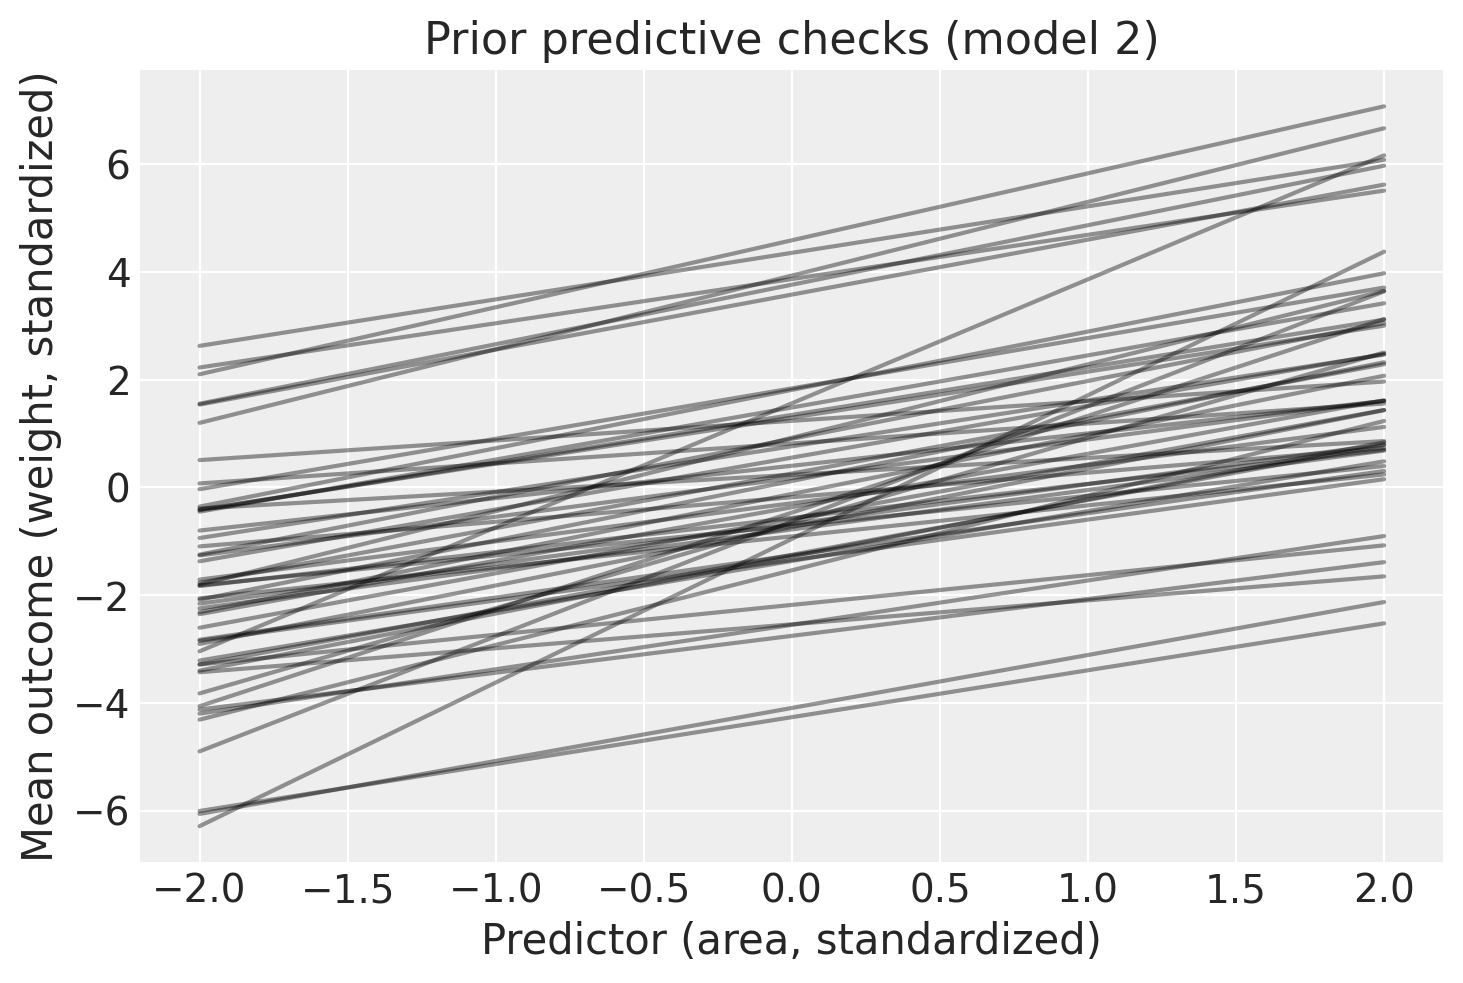

<IPython.core.display.Javascript object>

In [12]:
_, ax = plt.subplots()

x = np.linspace(-2, 2, 50)

for a, b in zip(prior_checks2["a"], prior_checks2["b_area"]):
    y = a + b * x
    ax.plot(x, y, c="k", alpha=0.4)

ax.set_xlabel("Predictor (area, standardized)")
ax.set_ylabel("Mean outcome (weight, standardized)")
ax.set_title("Prior predictive checks (model 2)")

The slope is still higher than I'd expect, but at least it's better. I'll leave it alone.

## Changes after checking with McElreath's solution

- Overall not too bad, but:
    - He had a tighter SD on the alpha. That makes sense. The alpha should be tight around zero if things are standardized.
    - He used a normal distribution on b_area, not lognormal. I suppose we can't necessarily make the assumption that area will have a positive influence on weight?

He did this for his model:
```
W ~ dnorm( mu , sigma )
mu <- a + bA*A,
a ~ dnorm(0,0.2),
bA ~ dnorm(0,0.5)
sigma ~ dexp(1)
```
- I should've checked my summary as a quick check.

In [13]:
az.summary(trace_m2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.001,0.098,-0.154,0.153,0.001,0.002,4802.0,1665.0,4840.0,2692.0,1.0
b_area,0.235,0.058,0.144,0.326,0.001,0.001,4926.0,4788.0,4839.0,2466.0,1.0
sigma,1.032,0.072,0.918,1.144,0.001,0.001,5069.0,5007.0,5102.0,2775.0,1.0


<IPython.core.display.Javascript object>

I noticed that my interval for `b_area` is all positive, but his answer encapsulates zero. Re-run with his parameters.

In [14]:
with pm.Model() as weights_model3:

    # Priors are variables a, b_area, sigma
    a = pm.Normal("a", mu=0, sd=0.2)
    b_area = pm.Normal("b_area", mu=0, sd=0.5)  # Make this smaller
    sigma = pm.Exponential("sigma", 1)

    # Linear model
    # Data included here (d2['area'] which is observed)
    mu = a + b_area * (d2["area"])

    # Likelihood is height variable, which is also observed (data included here, d2.height))
    # Height is dependent on deterministic and stochastic variables
    weight = pm.Normal("weight", mu=mu, sd=sigma, observed=d2["weight"])

    # This next line is doing the fitting and sampling all at once.
    # Using return_inferencedata = True to use arviz objects directly
    trace_m3 = pm.sample(1000, tune=1000, return_inferencedata=True)

    # Prior checks
    prior_checks3 = pm.sample_prior_predictive(samples=50, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_area, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Prior predictive checks (model 3)')

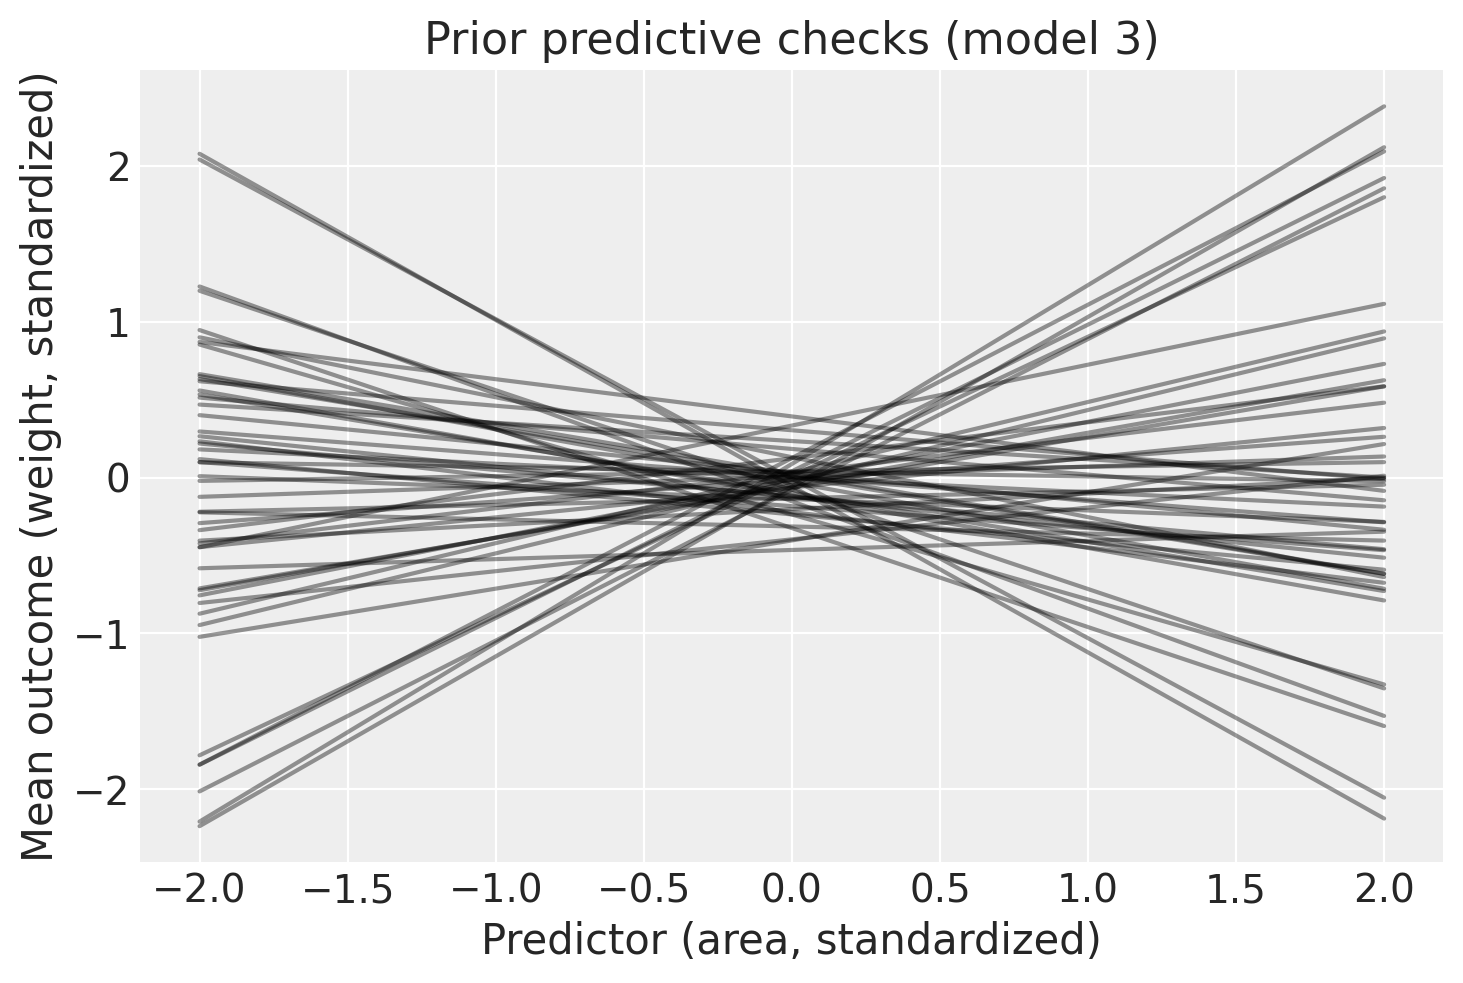

<IPython.core.display.Javascript object>

In [15]:
_, ax = plt.subplots()

x = np.linspace(-2, 2, 50)

for a, b in zip(prior_checks3["a"], prior_checks3["b_area"]):
    y = a + b * x
    ax.plot(x, y, c="k", alpha=0.4)

ax.set_xlabel("Predictor (area, standardized)")
ax.set_ylabel("Mean outcome (weight, standardized)")
ax.set_title("Prior predictive checks (model 3)")

In [16]:
az.summary(trace_m3)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.001,0.085,-0.134,0.134,0.001,0.001,5414.0,1948.0,5417.0,3004.0,1.0
b_area,0.019,0.092,-0.122,0.174,0.001,0.002,5203.0,1748.0,5170.0,2748.0,1.0
sigma,1.010,0.069,0.904,1.120,0.001,0.001,5058.0,4983.0,5094.0,2845.0,1.0


<IPython.core.display.Javascript object>

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

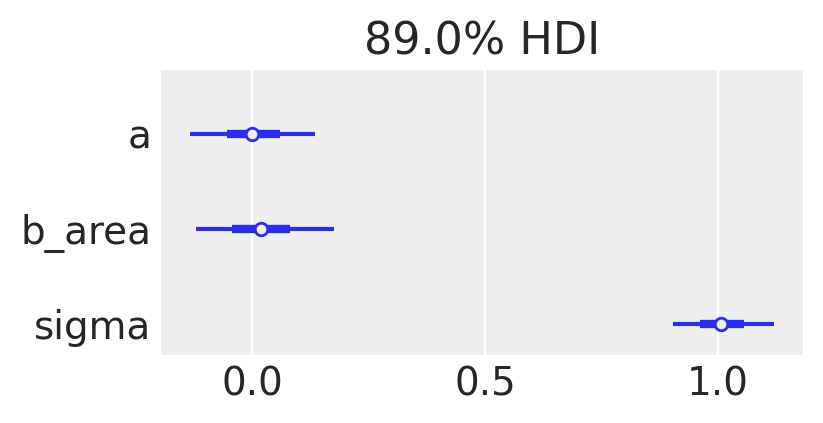

<IPython.core.display.Javascript object>

In [24]:
f, ax1 = plt.subplots(figsize=(4, 2))
az.plot_forest(trace_m3, combined=True, ax=ax1)

## Summary

We would conclude that there's no causal influence of `area` on `weight` in this sample.

# Question 2

**Now infer the causal impact of adding food (`avgfood`) to a territory. Would this make foxes heavier? Which covariates do you need to adjust for to estimate the total causal influence of food?**

Intuitively, I would expect that adding `avgfood` would make the foxes heavier. However, one potential question is what to do with `groupsize`, since the DAG shows `avgfood` pointing to it. We don't have to worry about it, because, while there it creates an indirect path, the arrow is pointing away from `avgfood`. The arrow pointing to `avgfood` from `area` is also something we can ignore because there is no other path from `area` to `weight`.

$\text{weight}_i$ ~ Normal($\mu_i, \sigma$)
<br>
$\mu_i = \alpha + \beta_{\text{avgfood}}x_i$
<br>
$\alpha$ ~ $\text{Normal}(0, 2)$
<br>
$\beta_{\text{avgfood}}$ ~ $\text{Log-Normal}(0, 1)$
<br>
$\sigma$ ~ $\text{Exp}(1)$

In [25]:
with pm.Model() as weights_model4:

    # Priors are variables a, b_area, sigma
    a = pm.Normal("a", mu=0, sd=0.2)
    b_avgfood = pm.Normal("b_avgfood", mu=0, sd=0.5)  # Make this smaller
    sigma = pm.Exponential("sigma", 1)

    # Linear model
    # Data included here (d2['area'] which is observed)
    mu = a + b_avgfood * (d2["avgfood"])

    # Likelihood is height variable, which is also observed (data included here, d2.height))
    # Height is dependent on deterministic and stochastic variables
    weight = pm.Normal("weight", mu=mu, sd=sigma, observed=d2["weight"])

    # This next line is doing the fitting and sampling all at once.
    # Using return_inferencedata = True to use arviz objects directly
    trace_m4 = pm.sample(1000, tune=1000, return_inferencedata=True)

    # Prior checks
    prior_checks4 = pm.sample_prior_predictive(samples=50, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_avgfood, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


<IPython.core.display.Javascript object>

In [26]:
az.summary(trace_m4)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.001,0.085,-0.137,0.133,0.001,0.001,4605.0,2144.0,4595.0,2897.0,1.0
b_avgfood,-0.027,0.097,-0.184,0.125,0.001,0.002,4626.0,1941.0,4654.0,2397.0,1.0
sigma,1.010,0.069,0.904,1.122,0.001,0.001,4232.0,4188.0,4277.0,2634.0,1.0


<IPython.core.display.Javascript object>

We would conclude that there's no causal influence of `avgfood` on `weight` in this sample.

My overall approach was correct but here's additional insight from the solutions: It should not surprise us that there is no influence of `avgfood` on `weight`. We already saw that `area`, which was upstream of `avgfood`, did not influence `weight`, so we would not have expected `avgfood` to show a difference since it is in between those two points in the graph.

# Question 3

**Now infer the causal impact of `group size`. Which covariates do you need to adjust for? Looking at the posterior distribution of the resulting model, what do you think explains these data? That is, can you explain the estimates for all three problems? How do they make sense together?**

In this case, we do have to worry about a backdoor path for `groupsize`, since there's the relationship:
`groupsize` <- `avgfood` -> `weight`. To account for this, we would need to include `avgfood` in the model.

$\text{weight}_i$ ~ Normal($\mu_i, \sigma$)
<br>
$\mu_i = \alpha + \beta_{\text{avgfood}}x_i + \beta_{\text{groupsize}}x_i$
<br>
$\alpha$ ~ $\text{Normal}(0, 2)$
<br>
$\beta_{\text{avgfood}}$ ~ $\text{Log-Normal}(0, 1)$
<br>
$\beta_{\text{groupsize}}$ ~ $\text{Log-Normal}(0, 1)$
<br>
$\sigma$ ~ $\text{Exp}(1)$

In [27]:
with pm.Model() as weights_model5:

    # Priors are variables a, b_area, sigma
    a = pm.Normal("a", mu=0, sd=0.2)
    b_avgfood = pm.Normal("b_avgfood", mu=0, sd=0.5)  # Make this smaller
    b_groupsize = pm.Normal("b_groupsize", mu=0, sd=0.5)  # Make this smaller
    sigma = pm.Exponential("sigma", 1)

    # Linear model
    # Data included here (d2['area'] which is observed)
    mu = a + b_avgfood * (d2["avgfood"]) + b_groupsize * (d2["groupsize"])

    # Likelihood is height variable, which is also observed (data included here, d2.height))
    # Height is dependent on deterministic and stochastic variables
    weight = pm.Normal("weight", mu=mu, sd=sigma, observed=d2["weight"])

    # This next line is doing the fitting and sampling all at once.
    # Using return_inferencedata = True to use arviz objects directly
    trace_m5 = pm.sample(1000, tune=1000, return_inferencedata=True)

    # Prior checks
    prior_checks5 = pm.sample_prior_predictive(samples=50, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_groupsize, b_avgfood, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


<IPython.core.display.Javascript object>

In [28]:
az.summary(trace_m5)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.001,0.082,-0.131,0.127,0.001,0.001,3252.0,1884.0,3272.0,2688.0,1.0
b_avgfood,0.472,0.186,0.184,0.769,0.004,0.003,2359.0,2359.0,2362.0,2656.0,1.0
b_groupsize,-0.571,0.188,-0.869,-0.283,0.004,0.003,2356.0,2356.0,2366.0,2614.0,1.0
sigma,0.963,0.064,0.865,1.067,0.001,0.001,2721.0,2711.0,2727.0,1778.0,1.0


<IPython.core.display.Javascript object>

In [ ]:
az.summary(trace_m5)

We now have a pretty strong positive association of `avgfood` with `weight`, after controlling for `groupsize`. We also see that `groupsize` is negatively associated with `weight`, controlling for `avgfood`. This makes sense because the more food, the heavier we would expect them to be (which makes the result of the second question surprising on the surface), but not if the food has to be shared with more individuals (larger `groupsize`).

More insight from the solutions:
> The total causal influence of food is still nothing, since it causes larger groups. This is a masking effect, like in the milk energy example. But the causal explanation here is that more foxes move into a territory until the food available to each is no better than the food in a neighboring territory. Every territory ends up equally good/bad on average. This is known in behavioral ecology as an *ideal free distribution*.

This is a case where two variables are correlated but one is positively associated and another is negatively associated with the outcome. In addition, the two variables `avgfood` and `groupsize` are correlated with each other as shown below.

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

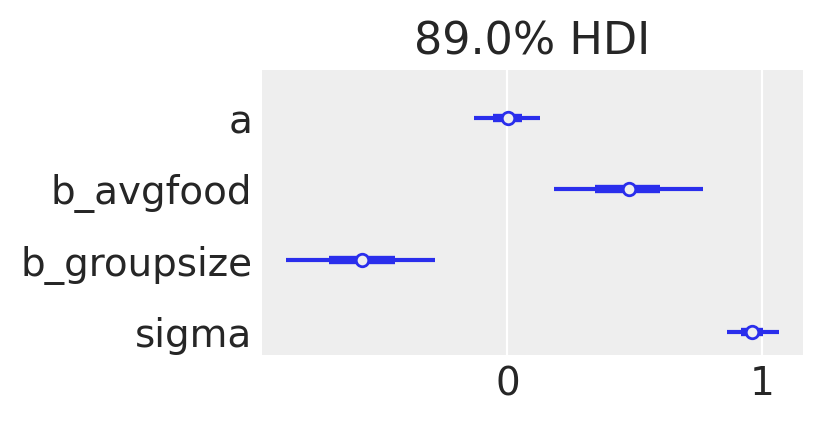

<IPython.core.display.Javascript object>

In [29]:
f, ax1 = plt.subplots(figsize=(4, 2))
az.plot_forest(trace_m5, combined=True, ax=ax1)

In [24]:
d2[["avgfood", "groupsize"]].corr()

,avgfood,groupsize
avgfood,1.000000,0.901483
groupsize,0.901483,1.000000


<IPython.core.display.Javascript object>

The Chapter 6 [pymc3 repo](https://github.com/pymc-devs/resources/blob/master/Rethinking_2/End_of_chapter_problems/Chapter_6.ipynb) also has some insight.

# Appendix: Environment and system parameters

In [25]:
%watermark -n -u -v -iv -w

Last updated: Sat Mar 13 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

numpy     : 1.20.1
seaborn   : 0.11.1
arviz     : 0.11.1
matplotlib: 3.3.4
daft      : 0.1.0
scipy     : 1.6.0
json      : 2.0.9
pymc3     : 3.11.0
pandas    : 1.2.1

Watermark: 2.1.0



<IPython.core.display.Javascript object>

In [26]:
# Custom scripts to show packages and versions in this notebook
def imports():
    import types

    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__


imported_packages = list(imports())

from active_pkg import show_pkg_vers_in_nb

show_pkg_vers_in_nb(imported_packages)

# Name                    Version                   Build  Channel
arviz                     0.11.1                   pypi_0    pypi
daft                      0.1.0                    pypi_0    pypi
matplotlib                3.3.4                    pypi_0    pypi
numpy                     1.20.1                   pypi_0    pypi
pandas                    1.2.1                    pypi_0    pypi
pymc3                     3.11.0                   pypi_0    pypi
scipy                     1.6.0                    pypi_0    pypi
seaborn                   0.11.1                   pypi_0    pypi


<IPython.core.display.Javascript object>